# Navier-Stokes Forward Simulation

Now let's target a somewhat more complex example: a fluid simulation based on the Navier-Stokes equations. This is still very simple with Φ<sub>Flow</sub> (phiflow), as differentiable operators for all steps of the simulator are already available in phiflow. The Navier-Stokes equations (in their incompressible form) introduce an additional pressure field $p$, and a constraint for conservation of mass, as introduced in equation {eq}`model-boussinesq2d`. We're also moving a marker field, denoted by $d$ here, with the flow. It indicates regions of higher temperature, and exerts a force via a buouyancy factor $\xi$:

$$\begin{aligned}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} &= - \frac{1}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u} + (0,1)^T \xi d
  \quad \text{s.t.} \quad \nabla \cdot \mathbf{u} = 0,
  \\
  \frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d &= 0
\end{aligned}$$


Here, we're aiming for an incompressible flow (i.e., $\rho = \text{const}$), and use a simple buoyancy model (the Boussinesq approximation) via the term $(0,1)^T \xi d$. This approximates changes in density for incompressible solvers, without explicitly calculating $\rho$. We assume a gravity force that acts along the y direction via the vector $(0,1)^T$.
We'll solve this PDE on a closed domain with Dirichlet boundary conditions $\mathbf{u}=0$ for the velocity, and Neumann boundaries $\frac{\partial p}{\partial x}=0$ for pressure, on a domain $\Omega$ with a physical size of $100 \times 80$ units.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/overview-ns-forw.ipynb)



## Implementation

As in the previous section, the first command with a "!" prefix installs the [phiflow python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment. (Skip or modify this command if necessary.)

In [1]:
!pip install --upgrade --quiet phiflow==3.4
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.flow import *  # The Dash GUI is not supported on Google colab, ignore the warning
import pylab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.4/355.4 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Setting up the simulation

The following code sets up a few constants, which are denoted by upper case names. We'll use $40 \times 32$ cells to discretize our domain, introduce a slight viscosity via $\nu$, and define the time step to be $\Delta t=1.5$.

We're creating a first `CenteredGrid` here, which is initialized by a `Sphere` geometry object. This will represent the inflow region `INFLOW` where hot smoke is generated.

In [22]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100))) * 0.2


The inflow will be used to inject smoke into a second centered grid `smoke` that represents the marker field $d$ from above. Note that we've defined a `Box` of size $100 \times 80$ above. This is the physical scale in terms of spatial units in our simulation, i.e., a velocity of magnitude $1$ will move the smoke density by 1 unit per 1 time unit, which may be larger or smaller than a cell in the discretized grid, depending on the settings for `x,y`. You could parametrize your simulation grid to directly resemble real-world units, or keep appropriate conversion factors in mind.

The inflow sphere above is already using the "world" coordinates: it is located at $x=30$ along the first axis, and $y=15$ (within the $100 \times 80$ domain box).

Next, we create grids for the quantities we want to simulate. For this example, we require a velocity field and a smoke density field.

In [23]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers

We sample the smoke field at the cell centers and the velocity in [staggered form](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html). The staggered grid internally contains 2 centered grids with different dimensions, and can be converted into centered grids (or simply numpy arrays) via the `unstack` function, as explained in the link above.

Next we define the update step of the simulation, which calls the necessary functions to advance the state of our fluid system by `dt`. The next cell computes one such step, and plots the marker density after one simulation frame.

Max. velocity and mean marker density: [0.15584606, 0.008125]


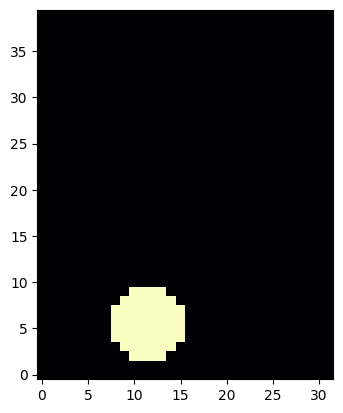

In [24]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity, (), Solve('CG', 1e-3))
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

A lot has happened in this `step()` call: we've advected the smoke field, added an upwards force via a Boussinesq model, advected the velocity field, and finally made it divergence free via a pressure solve.

The Boussinesq model uses a multiplication by a tuple `(0, buoyancy_factor)` to turn the smoke field into a staggered, 2 component force field, sampled at the locations of the velocity components via the `at()` function. This function makes sure the individual force components are correctly interpolated for the velocity components of the staggered velocity. Note that this also directly ensure the boundary conditions of the original grid are kept. It internally also does `StaggeredGrid(..., extrapolation.ZERO,...)` for the resulting force grid.

The pressure projection step in `make_incompressible` is typically the computationally most expensive step in the sequence above. It solves a Poisson equation for the boundary conditions of the domain, and updates the velocity field with the gradient of the computed pressure.

Just for testing, we've also printed the mean value of the velocities, and the max density after the update. As you can see in the resulting image, we have a first round region of smoke, with a slight upwards motion (which does not show here yet).

## Datatypes and dimensions

The variables we created for the fields of the simulation here are instances of the class `Grid`.
Like tensors, grids also have the `shape` attribute which lists all batch, spatial and channel dimensions.
[Shapes in phiflow](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) store not only the sizes of the dimensions but also their names and types.

In [25]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}, spatial only: {INFLOW.shape.spatial}")


Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (xˢ=32, yˢ=40), spatial only: (xˢ=32, yˢ=40)


Note that the phiflow output here indicates the type of a dimension, e.g., $^S$ for a spatial, and $^V$ for a vector dimension. Later on for learning, we'll also introduce batch dimensions.

The actual content of a shape object can be obtained via `.sizes`, or alternatively we can query the size of a specific dimension `dim` via `.get_size('dim')`. Here are two examples:

In [26]:
print(f"Shape content: {velocity.shape.sizes}")
print(f"Vector dimension: {velocity.shape.get_size('vector')}")

Shape content: (32, 40, 2)
Vector dimension: 2


The grid values can be accessed using the `values` property. This is an important difference to a phiflow tensor object, which does not have `values`, as illustrated in the code example below.

In [27]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)

# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([3, 5, 2]), spatial('x,y'), channel(vector="x,y"))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) ) # reorder to vector,y,x
#print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(~vectorᵈ=x,y, xˢ=~(x=31, y=32) int64, yˢ=~(x=40, y=39) int64) 1.23e-06 ± 2.8e-02 (-1e-01...2e-01)
Reordered test tensor shape: (2, 5, 3)


Grids have many more properties which are documented [here](https://tum-pbs.github.io/PhiFlow/phi/field/#phi.field.Grid).
Also note that the staggered grid has a [non-uniform shape](https://tum-pbs.github.io/PhiFlow/Math.html#non-uniform-tensors) because the number of faces is not equal to the number of cells (in this example the x component has $31 \times 40$ cells, while y has $32 \times 39$). The `INFLOW` grid naturally has the same dimensions as the `smoke` grid.


## Time evolution

With this setup, we can easily advance the simulation forward in time a bit more by repeatedly calling the `step` function.

In [28]:
for time_step in range(5):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))


Computed frame 0, max velocity 0.4629918932914734
Computed frame 1, max velocity 0.8966975212097168
Computed frame 2, max velocity 1.409925937652588
Computed frame 3, max velocity 2.0410590171813965
Computed frame 4, max velocity 2.928074359893799


Now the hot plume is starting to rise:

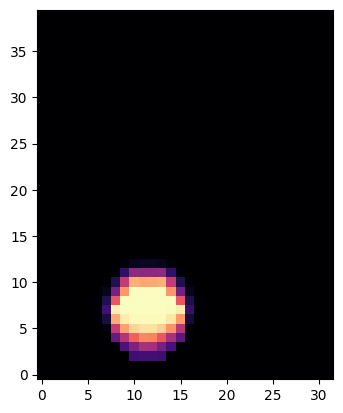

In [29]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Let's compute and show a few more steps of the simulation. Because of the inflow being located off-center to the left (with x position 30), the plume will curve towards the right when it hits the top wall of the domain.

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


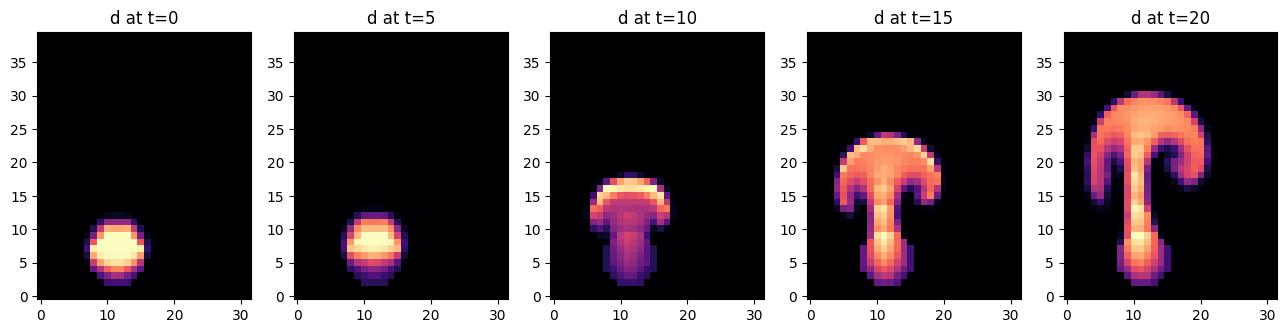

In [30]:
steps = [[ smoke.values, velocity.vector['x'], velocity.vector['y'] ]]
for time_step in range(20):
  if time_step<3 or time_step%10==0:
    print('Computing time step %d' % time_step)
  velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
  if time_step%5==0:
    steps.append( [smoke.values, velocity.vector['x'], velocity.vector['y']] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*5}")

We can also take a look at the velocities. The `steps` list above already stores `vector[0]` and `vector[1]` components of the velocities as numpy arrays, which we can show next.

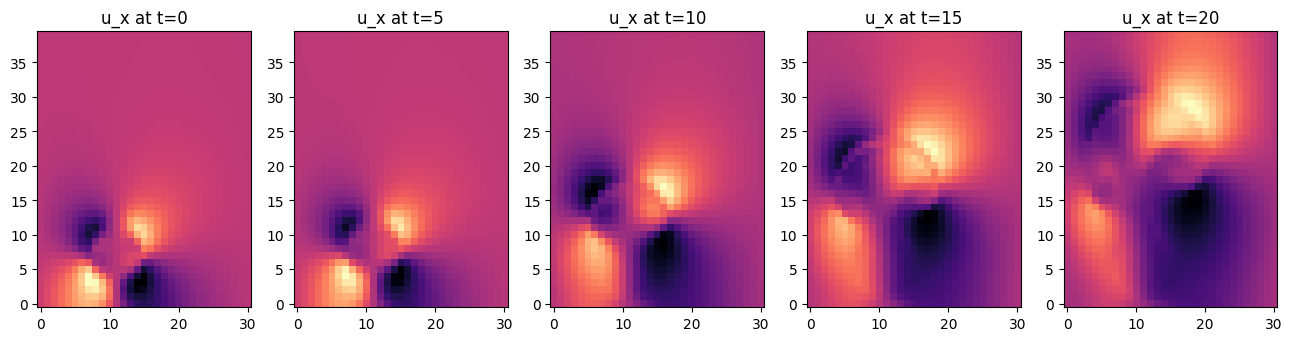

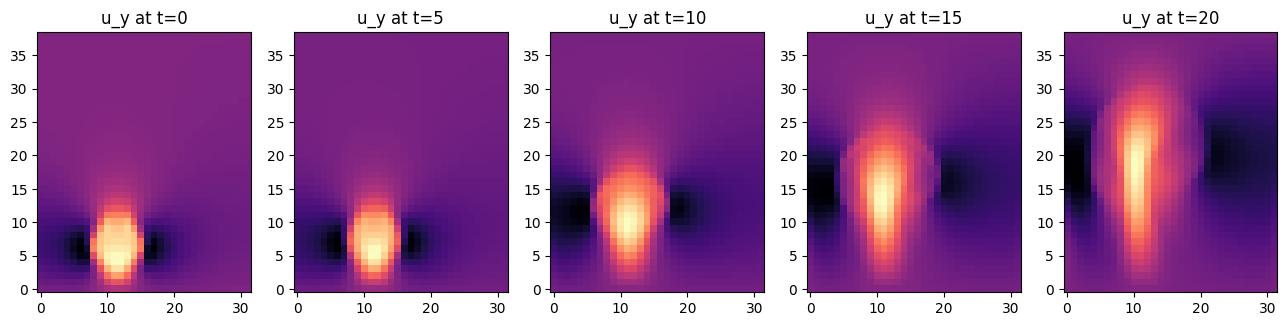

In [31]:
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_x at t={i*5}")

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_y at t={i*5}")


It looks simple here, but this simulation setup is a powerful tool. The simulation could easily be extended to more complex cases or 3D, and it is already fully compatible with backpropagation pipelines of deep learning frameworks.

In the next chapters we'll show how to use these simulations for training NNs, and how to steer and modify them via trained NNs. This will illustrate how much we can improve the training process by having a solver in the loop, especially when the solver is _differentiable_. Before moving to these more complex training processes, we will cover a simpler supervised approach in the next chapter. This is very fundamental: even when aiming for advanced physics-based learning setups, a working supervised training is always the first step.

## Next steps

You could create a variety of nice fluid simulations based on this setup. E.g., try changing the spatial resolution, the buoyancy factors, and the overall length of the simulation run.

# Conclusion
这部分代码主要阐述了如何基于Phiflow 和 Boussiness Eq (一种含有浮力项的纳维尔斯托克斯方程)来对底面注入的smoke进行2D仿真，值得注意的是，本文采用的网格是Centered Grid，一种结构化规则网格，每个网格的性质都集中在网格中心点，该网格与非结构化网格的四面体、四边形等不同，其不依赖高斯积分。
显然，**Centered Gird** 无法获取刚度矩阵，只能使用显式更新方法，比如有限差分法。